In [ ]:
import numpy as np 
import pandas as pd 
import librosa as lb
import librosa.display
import soundfile as sf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torch.nn.functional as F  
import torchvision
from torchvision import datasets, models, transforms
# import torchmetrics
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import seaborn as sns
import time
import copy
import warnings
warnings.filterwarnings("ignore")

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# Data Pre-processing

## Process text file

In [ ]:
# Read patient data file
patient_data=pd.read_csv('/kaggle/input/respiratory-sound-database-v2/Respiratory_Sound_Database/patient_diagnosis.csv',names=['pid','disease'])

# Print 8 classes that we will be classifying
patient_data["disease"].value_counts()

COPD              64
Healthy           26
URTI              14
Bronchiectasis     7
Pneumonia          6
Bronchiolitis      6
LRTI               2
Asthma             1
Name: disease, dtype: int64

In [ ]:
# Extract text information for audios, text information such as cycle start and end time, 
# number of wheezles and crakles (which is not the focus in our case)
path = '/kaggle/input/respiratory-sound-database-v2/Respiratory_Sound_Database/audio_and_txt_files/'
files = [file_name for file_name in os.listdir(path) if '.txt' in file_name]
files_data = []
for file_name in files:
    data = pd.read_csv(path + file_name,sep='\t',names=['start','end','crackles','wheezes'])
    name_data = file_name.split('_')
    data['pid'] = name_data[0]
    data['mode'] = name_data[-2]
    data['filename'] = file_name
    files_data.append(data)
files_df=pd.concat(files_data)

# Join patient's disease with text information for audio
patient_data.pid=patient_data.pid.astype('int32')
files_df.pid=files_df.pid.astype('int32')
data=pd.merge(files_df,patient_data,on='pid')
original_data = pd.merge(files_df,patient_data,on='pid')

# Discard patients information, whose has the most common class COPD
data.sort_values(["disease","pid","start"],inplace=True,ignore_index=True)
data.head()
COPD_data=data[data["disease"]=="COPD"]
COPD_data.sort_values(["pid","start"],inplace=True,ignore_index=True)
COPD_data=COPD_data[:524]
COPD_data
data.drop(data[data["disease"]=="COPD"].index,inplace=True)
data=pd.concat([data,COPD_data])
data.sort_values(["disease","pid","start"],inplace=True,ignore_index=True)

data.head()

,start,end,crackles,wheezes,pid,mode,filename,disease
0,0.364,3.250,0,1,103,mc,103_2b2_Ar_mc_LittC2SE.txt,Asthma
1,3.250,6.636,0,0,103,mc,103_2b2_Ar_mc_LittC2SE.txt,Asthma
2,6.636,11.179,0,1,103,mc,103_2b2_Ar_mc_LittC2SE.txt,Asthma
3,11.179,14.250,0,1,103,mc,103_2b2_Ar_mc_LittC2SE.txt,Asthma
4,14.250,16.993,0,1,103,mc,103_2b2_Ar_mc_LittC2SE.txt,Asthma


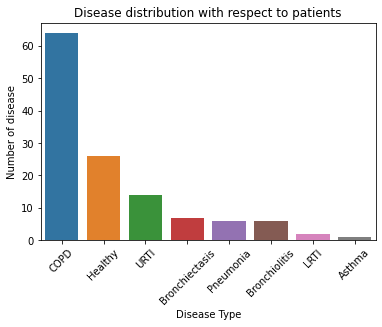

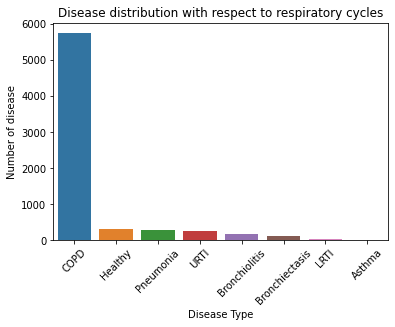

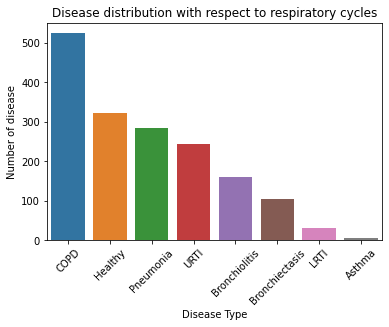

In [ ]:
# Show imbalance in disease class w.r.t patients
sns.countplot(x = patient_data['disease'], order = patient_data['disease'].value_counts().index)
plt.xticks(rotation = 45)
plt.xlabel('Disease Type')
plt.ylabel('Number of disease')
plt.title("Disease distribution with respect to patients")
plt.show()

# Show imbalance in disease class w.r.t respiratory cycles
sns.countplot(x = original_data['disease'], order = original_data['disease'].value_counts().index)
plt.xticks(rotation = 45)
plt.xlabel('Disease Type')
plt.ylabel('Number of disease')
plt.title("Disease distribution with respect to respiratory cycles")
plt.show()

# Show balanced data in disease class w.r.t respiratory cycles
sns.countplot(x = data['disease'], order = data['disease'].value_counts().index)
plt.xticks(rotation = 45)
plt.xlabel('Disease Type')
plt.ylabel('Number of disease')
plt.title("Disease distribution with respect to respiratory cycles")
plt.show()

In [ ]:
# Create an CSV file containing all text information for audio
os.makedirs('D:/桌面/Respiratory_Sound_Database/output_works2')
data.to_csv('D:/桌面/Respiratory_Sound_Database/output_works2/text_data.csv',index=False)

## Process audio files

To do
1. Each audio file have multiple respiratory cycles, extract those cycles from one file and make them into independent files. 
2. When extracting, the length of the audio should be consistent, in purpose of future feature extraction. By far the best length is 6s. (Need proof). In order to do so, add slience period to ones <6s and cut ones >6s.
3. Noise removal.

Cycle Mean Seconds:  2.282674403341289


<AxesSubplot:>

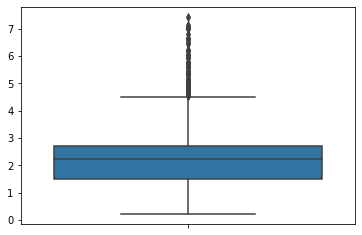

In [ ]:
# Find the standard time length for each cycle
print("Cycle Mean Seconds: ", (data.end - data.start).mean())
sns.boxplot(y=(data.end-data.start))

### Trim Audio Files

In [ ]:
#########################################################
#                 Select audio files to trim
#########################################################
# os.makedirs("audio_files_for_balancing")
selected_filenames=data["filename"]
lst_selected_filenames=[i.split('.')[0]+".wav" for i in selected_filenames]
set_selected_filenames=set(lst_selected_filenames)
set_selected_filenames
print(len(set_selected_filenames))
# path='/kaggle/input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/'
# name_audio_files=[file_name for file_name in os.listdir(path) if '.wav' in file_name]

185


In [ ]:
#########################################################
#                 Trim audio files using librosa
#########################################################
path='D:/桌面/Respiratory_Sound_Database/audio_and_txt_files/'
total_file_processed = 0
os.mkdir('D:/桌面/Respiratory_Sound_Database/output_works2/processed_audio_files/')
# loop every audio file
for audio_file in set_selected_filenames:
    cycle_num = 0
    text_file_df = data.loc[data['filename'] == audio_file.split(".")[0]+'.txt']
    audio, sr = lb.load(path + audio_file)
    # loop every cycle in one audio file
    for idx, row in text_file_df.iterrows():
        total_file_processed += 1
        cycle_num += 1
        # if cycle > 5s, keep the first 5s
        end = row['end']
        start = row['start']
        if (end - start) > 5:
            end = start + 5 
        # slice the samples
        max_ind = len(audio) 
        start_ind = min(int(start * sr), max_ind)
        end_ind = min(int(end * sr), max_ind)
        cycle = audio[start_ind: end_ind] 
        # if cycle < 5s, pad silence at both ends to 5s
        new_cycle = lb.util.pad_center(cycle, 5 * sr)
        # write cycle as an .wav file
        new_filename = row['filename'].split(".")[0] + "_cycle" + str(cycle_num) + ".wav"
        sf.write(file = "D:/桌面/Respiratory_Sound_Database/output_works2/processed_audio_files/" + new_filename, data = new_cycle, samplerate = sr)

print(total_file_processed)

C:\Users\Fassavoy\AppData\Local\Temp\ipykernel_5060\773078353.py:27: FutureWarning: Pass size=110250 as keyword args. From version 0.10 passing these as positional arguments will result in an error

  new_cycle = lb.util.pad_center(cycle, 5 * sr)


1676


In [ ]:
# deleted noise removal part
# # resample the audio file into 4kHZ
# os.mkdir('res_processed_audio_files')
# import soundfile as sf
# path="/kaggle/working/processed_audio_files/"# need to change right now just copy and paste
# pro_audio_files=[file_name for file_name in os.listdir(path) if '.wav' and "_cycle" in file_name]
# for audio_file in pro_audio_files:
#     print(audio_file)
#     src_sig,sr=sf.read(path+audio_file)
#     dst_sig=lb.resample(src_sig,orig_sr=sr,target_sr=4000)
#     sf.write("/kaggle/working/res_processed_audio_files/"+audio_file,dst_sig,4000)


148_1b1_Al_sc_Meditron_cycle8.wav

120_1b1_Lr_sc_Meditron_cycle33.wav

184_1b1_Ar_sc_Meditron_cycle3.wav

200_2p4_Pr_mc_AKGC417L_cycle4.wav

172_1b5_Pl_mc_AKGC417L_cycle2.wav

186_2b2_Tc_mc_AKGC417L_cycle5.wav

204_7p5_Ll_mc_AKGC417L_cycle6.wav

178_1b2_Pl_mc_AKGC417L_cycle4.wav

200_2p2_Pl_mc_AKGC417L_cycle5.wav

205_1b3_Lr_mc_AKGC417L_cycle4.wav

223_1b1_Ar_sc_Meditron_cycle3.wav

213_2p2_Pl_mc_AKGC417L_cycle2.wav

211_1p5_Ar_mc_AKGC417L_cycle4.wav

213_2p2_Tc_mc_AKGC417L_cycle5.wav

150_1b2_Al_sc_Meditron_cycle7.wav

147_1b3_Tc_mc_AKGC417L_cycle8.wav

104_1b1_Pl_sc_Litt3200_cycle8.wav

113_1b1_Lr_sc_Litt3200_cycle1.wav

203_1p2_Al_mc_AKGC417L_cycle1.wav

163_8b3_Pl_mc_AKGC417L_cycle5.wav

218_1b1_Al_sc_Meditron_cycle1.wav

186_3b3_Tc_mc_AKGC417L_cycle2.wav

170_2b2_Al_mc_AKGC417L_cycle5.wav

130_1p2_Tc_mc_AKGC417L_cycle4.wav

218_1b1_Ar_sc_Meditron_cycle16.wav

126_1b1_Al_sc_Meditron_cycle6.wav

130_2b3_Pr_mc_AKGC417L_cycle3.wav

138_1p4_Tc_mc_AKGC417L_cycle2.wav

166_1p1_Ll_sc_Medi

## Create train and validation set

In [ ]:
# Combine audio data with class label (joint by patient ID) in order to split sets
patient_data_for_balancing=data[["pid","disease"]]
patient_data_for_balancing
path_for_balancing="/kaggle/input/respiratory-sound-database-v2/Respiratory_Sound_Database/output_works2/processed_audio_files/"
audio_files_for_balancing = [file_name for file_name in os.listdir(path_for_balancing)]
idx = 0
audio_df_for_balancing = pd.DataFrame(index = range(len(audio_files_for_balancing)), columns = ['pid', 'audio_filename_for_balancing'])
for file in os.listdir(path_for_balancing):
    audio_df_for_balancing.iloc[idx]['pid'] = file.split('_')[0]
    audio_df_for_balancing.iloc[idx]['audio_filename_for_balancing'] = file     
    idx += 1
audio_df_for_balancing.pid = audio_df_for_balancing.pid.astype('int64')
audio_df_for_balancing.sort_values("pid",inplace=True,ignore_index=True)
patient_data_for_balancing.sort_values("pid",inplace=True,ignore_index=True)
add_disease=patient_data_for_balancing["disease"]
data_for_balancing=audio_df_for_balancing
data_for_balancing["disease"]=add_disease

print('Number of Cycles:', len(data_for_balancing))
data_for_balancing.head()
# # Applying the method
# check_nan = data_for_balancing.isnull().values.any()
 
# # printing the result
# print(check_nan)

Number of Cycles: 1676


,pid,audio_filename_for_balancing,disease
0,101,101_1b1_Pr_sc_Meditron_cycle11.wav,URTI
1,101,101_1b1_Al_sc_Meditron_cycle12.wav,URTI
2,101,101_1b1_Pr_sc_Meditron_cycle10.wav,URTI
3,101,101_1b1_Pr_sc_Meditron_cycle5.wav,URTI
4,101,101_1b1_Pr_sc_Meditron_cycle1.wav,URTI


In [ ]:
# Split train and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(data_for_balancing['audio_filename_for_balancing'], data_for_balancing['disease'], stratify=data_for_balancing['disease'], test_size=0.2, random_state=42)

In [ ]:
y_train.value_counts() / y_train.shape[0]

COPD              0.312687
Healthy           0.191791
Pneumonia         0.170149
URTI              0.144776
Bronchiolitis     0.095522
Bronchiectasis    0.061940
LRTI              0.019403
Asthma            0.003731
Name: disease, dtype: float64

In [ ]:
y_val.value_counts() / y_val.shape[0]

COPD              0.312500
Healthy           0.193452
Pneumonia         0.169643
URTI              0.145833
Bronchiolitis     0.095238
Bronchiectasis    0.062500
LRTI              0.017857
Asthma            0.002976
Name: disease, dtype: float64

In [ ]:
# y_train is a panda series of string class representation
# we want to tranform string to class indices for traditional machine learning tasks
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(y_train)
list(le.classes_)
y_train_indices = le.transform(y_train)

le1 = preprocessing.LabelEncoder()
le1.fit(y_val)
list(le.classes_)
y_val_indices = le.transform(y_val)
# y_train_indices.shape

In [ ]:
print('Length of train set: ', len(X_train))
print('Length of validation set: ',len(X_val))

Length of train set:  1340
Length of validation set:  336


In [ ]:
# Add class label to train/val set
train = pd.merge(X_train, y_train, left_index = True, right_index = True)
val = pd.merge(X_val, y_val, left_index = True, right_index = True)

In [ ]:
train.to_csv('D:/桌面/Respiratory_Sound_Database/output_works2/train_set.csv')
val.to_csv('D:/桌面/Respiratory_Sound_Database/output_works2/val_set.csv')

In [ ]:
train=pd.read_csv('D:/桌面/Respiratory_Sound_Database/output_works2/train_set.csv')
val=pd.read_csv('D:/桌面/Respiratory_Sound_Database/output_works2/val_set.csv')
train.head()

,Unnamed: 0,audio_filename_for_balancing,disease
0,189,107_3p2_Pr_mc_AKGC417L_cycle3.wav,COPD
1,872,135_2b2_Al_mc_LittC2SE_cycle3.wav,Pneumonia
2,800,135_2b3_Pr_mc_LittC2SE_cycle7.wav,Pneumonia
3,780,135_2b2_Tc_mc_LittC2SE_cycle3.wav,Pneumonia
4,1262,183_1b1_Tc_sc_Meditron_cycle3.wav,Healthy


## Audio Data Transformation

### Convert to MFCC

In [ ]:
def convert_to_mfcc(filenames):
    path = '/kaggle/input/respiratory-sound-database-v2/Respiratory_Sound_Database/output_works2/processed_audio_files/'
    file = path + filenames.iloc[0]
    sound,sample_rate = lb.load(file,sr = None)
    All_mfccs = lb.feature.mfcc(y=sound, sr=sample_rate)
    file = path + filenames.iloc[1]
    sound,sr = lb.load(file,sr = None)
    mfcc = lb.feature.mfcc(y=sound, sr=sample_rate)
    All_mfccs = np.append([All_mfccs], [mfcc], axis = 0)
    for i in range (2, len(filenames)):
        file = path + filenames.iloc[i]
        sound,sr = lb.load(file,sr = None)
        mfcc = lb.feature.mfcc(y=sound, sr=sample_rate)
        All_mfccs = np.append(All_mfccs, [mfcc], axis = 0)
    return All_mfccs

In [ ]:
train_mfccs = convert_to_mfcc(X_train)
print(train_mfccs.shape)
val_mfccs = convert_to_mfcc(X_val)
print(val_mfccs.shape)

(1340, 20, 216)

(336, 20, 216)


### Convert to Mel-spectrogram

In [ ]:
# Convert to mel-spectrogram using pytorch torchaudio
import torchaudio
def spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None): # 64 can be changed, which decide the output dimension of the tensor
    sig,sr = aud
    top_db = 80

    # spec has shape [channel, n_mels, time], where channel is mono, stereo etc
    spec = torchaudio.transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)

    # Convert to decibels
    spec = torchaudio.transforms.AmplitudeToDB(top_db=top_db)(spec)
    return (spec.numpy())
def convert_to_spec(filenames):
    file = path + filenames.iloc[0]
    aud= torchaudio.load(file)
    all_spec = spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None)
    file = path + filenames.iloc[1]
    aud= torchaudio.load(file)
    spec = spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None)
    all_spec = np.append([all_spec], [spec], axis = 0)
    for i in range (2, len(filenames)):
        file = path + filenames.iloc[i]
        aud= torchaudio.load(file)
        spec = spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None)
        all_spec = np.append(all_spec, [spec], axis = 0)
    return all_spec

D:\Anaconda\lib\site-packages\torchaudio\extension\extension.py:14: UserWarning: torchaudio C++ extension is not available.

  warnings.warn('torchaudio C++ extension is not available.')

D:\Anaconda\lib\site-packages\torchaudio\backend\utils.py:63: UserWarning: The interface of "soundfile" backend is planned to change in 0.8.0 to match that of "sox_io" backend and the current interface will be removed in 0.9.0. To use the new interface, do `torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE = False` before setting the backend to "soundfile". Please refer to https://github.com/pytorch/audio/issues/903 for the detail.

  warnings.warn(


In [ ]:
path = 'D:/桌面/Respiratory_Sound_Database/output_works2/processed_audio_files/'
filenames = X_train
train_spec = convert_to_spec(X_train)
print(train_spec.shape)
val_spec = convert_to_spec(X_val)
print(val_spec.shape)

D:\Anaconda\lib\site-packages\torch\functional.py:515: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  ..\aten\src\ATen\native\SpectralOps.cpp:653.)

  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore

D:\Anaconda\lib\site-packages\torch\functional.py:515: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  ..\aten\src\ATen\native\SpectralOps.cpp:590.)

  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore


(1340, 1, 64, 216)

(336, 1, 64, 216)


In [ ]:
# Convert to mel-spectrogram using librosa and save figures
def convert_save(filenames, output_path):
    path = 'D:/桌面/Respiratory_Sound_Database/output_works2/processed_audio_files/'
    for i in range (0, len(filenames)): #len(filenames)
        file = path + filenames.iloc[i].audio_filename_for_balancing
        sound,sample_rate = lb.load(file,sr = None)

        # Short-time Fourier transform: decomposes the signal into its constituent frequencies 
        # and displays the amplitude of each frequency present in the signal
        sgram = lb.stft(sound)
        mel_scale_sgram = librosa.feature.melspectrogram(y=sound, sr=sample_rate, power=1) # energy1 instead of power2
        # use the decibel scale to get the final Mel Spectrogram
        mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=np.min)
        
        fig = plt.Figure()
        canvas = FigureCanvas(fig)
        ax = fig.add_subplot()
        p = librosa.display.specshow(mel_sgram, ax = ax)
        
        # save fig differently under different directories based on their class label
        try: 
            os.mkdir(output_path + filenames.iloc[i].disease + '/')
            output = output_path + filenames.iloc[i].disease + '/'
        except:
            output = output_path + filenames.iloc[i].disease + '/'
        fig.savefig(output + filenames.iloc[i].audio_filename_for_balancing.split('.')[0] + '.png', bbox_inches='tight')

In [ ]:
os.mkdir('D:/桌面/Respiratory_Sound_Database/output_works2/melspectrograms/')
os.mkdir('D:/桌面/Respiratory_Sound_Database/output_works2/melspectrograms/train')
convert_save(train, 'D:/桌面/Respiratory_Sound_Database/output_works2/melspectrograms/train/')
os.mkdir('D:/桌面/Respiratory_Sound_Database/output_works2/melspectrograms/val')
convert_save(val, 'D:/桌面/Respiratory_Sound_Database/output_works2/melspectrograms/val/')

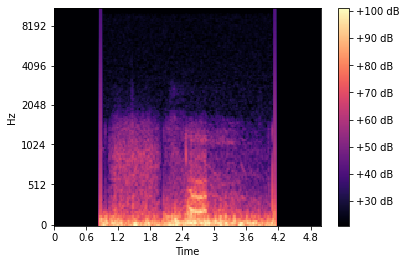

In [ ]:
# Display one mel spectrogram example
path = 'D:/桌面/Respiratory_Sound_Database/output_works2/processed_audio_files/'
file = path + X_train.iloc[60]
sound,sample_rate = lb.load(file,sr = None)

# Short-time Fourier transform: decomposes the signal into its constituent frequencies 
# and displays the amplitude of each frequency present in the signal
sgram = lb.stft(sound)
mel_scale_sgram = librosa.feature.melspectrogram(y=sound, sr=sample_rate, power=1) # energy1 instead of power2
# use the decibel scale to get the final Mel Spectrogram
mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=np.min)

librosa.display.specshow(mel_sgram, sr=sample_rate, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')

# Feature Extraction & Model Creation

## Tranditional ML

### MFCCs Feature Vector Creation

In [ ]:
train_mfccs = convert_to_mfcc(X_train)
print(train_mfccs.shape)
val_mfccs = convert_to_mfcc(X_val)
print(val_mfccs.shape)

(1340, 20, 216)
(336, 20, 216)


In [ ]:
# Flatten Mfccs array to feature vector
X_train_features = train_mfccs.reshape(train_mfccs.shape[0], train_mfccs.shape[1] * train_mfccs.shape[2])
X_val_features = val_mfccs.reshape(val_mfccs.shape[0], val_mfccs.shape[1] * val_mfccs.shape[2])

print('Train feature vector dimension: ', X_train_features.shape)
print('Validation feature vector dimension: ', X_val_features.shape)

Train feature vector dimension:  (1340, 4320)
Validation feature vector dimension:  (336, 4320)


In [ ]:
# Visualization of train features: Dimensionality Reduction 1: PCA
import numpy as np
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
array_2D = pca.fit_transform(X_train_features)
df_2D = pd.DataFrame(array_2D, columns = ['Dimension1','Dimension2'])
df_2D['Class'] = y_train.tolist()
df_2D['Dimension1']

0       2028.889282
1       2749.801025
2       2784.007324
3       -941.505554
4       -421.312958
           ...     
1335     330.441559
1336    3405.675537
1337     812.218323
1338   -1310.856934
1339   -2489.527344
Name: Dimension1, Length: 1340, dtype: float32

<AxesSubplot:>

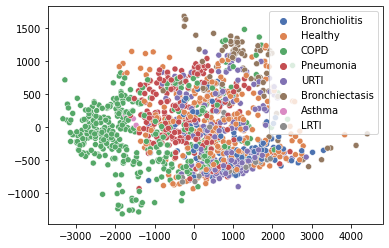

In [ ]:
sns.scatterplot(x=df_2D['Dimension1'].values, y=df_2D['Dimension2'].values, hue=df_2D['Class'].values, palette="deep")

In [ ]:
# Visualization of train features: Dimensionality Reduction 1: t-SNE
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, perplexity=30, learning_rate='auto',
                  init='random').fit_transform(X_train_features)
df_2D_tsne = pd.DataFrame(X_embedded, columns = ['Dimension1','Dimension2'])
df_2D_tsne['Class'] = y_train.tolist()

<AxesSubplot:>

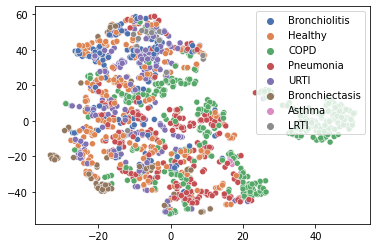

In [ ]:
sns.scatterplot(x=df_2D_tsne['Dimension1'].values, y=df_2D_tsne['Dimension2'].values, hue=df_2D_tsne['Class'].values, palette="deep")

### Model Creation & Training & Evaluation

#### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
# Create and train Decision Tree classifer object
clf = DecisionTreeClassifier().fit(X_train_features, y_train_indices)

# Predict the response for test dataset
y_pred = clf.predict(X_val_features)

# Evaluation: Accuracy 
print("Accuracy:", np.sum(y_pred == y_val_indices) / y_pred.shape[0])

Accuracy: 0.5952380952380952


#### SVM

In [ ]:
from sklearn import svm

# Create and Train Decision Tree classifer object
linear = svm.SVC(kernel='linear').fit(X_train_features, y_train_indices)
rbf = svm.SVC(kernel='rbf', gamma=1).fit(X_train_features, y_train_indices)
poly = svm.SVC(kernel='poly', degree=2).fit(X_train_features, y_train_indices)
sig = svm.SVC(kernel='sigmoid').fit(X_train_features, y_train_indices)

linear_pred = linear.predict(X_val_features)
poly_pred = poly.predict(X_val_features)
rbf_pred = rbf.predict(X_val_features)
sig_pred = sig.predict(X_val_features)

accuracy_lin = linear.score(X_val_features, y_val_indices)
accuracy_poly = poly.score(X_val_features, y_val_indices)
accuracy_rbf = rbf.score(X_val_features, y_val_indices)
accuracy_sig = sig.score(X_val_features, y_val_indices)

print('Accuracy Linear Kernel: ', accuracy_lin)
print('Accuracy Polynomial Kernel: ', accuracy_poly)
print('Accuracy Radial Basis Kernel: ', accuracy_rbf)
print('Accuracy Sigmoid Kernel: ', accuracy_sig)

Accuracy Linear Kernel:  0.7470238095238095
Accuracy Polynomial Kernel:  0.48214285714285715
Accuracy Radial Basis Kernel:  0.3125
Accuracy Sigmoid Kernel:  0.2916666666666667


## Neural Network: CNN + MLP

### Dataset and Dataloaders

In [ ]:
data_dir = '/kaggle/input/respiratory-sound-database-v2/Respiratory_Sound_Database/output_works2/melspectrograms'

# VGG-16 Takes 224x224 images as input, so we resize all of them
data_transforms = {
    'train': transforms.Compose([
        # Randomly flip images horizontally to do data augmentation
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
#         transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ])
}

image_datasets = {
    'train': datasets.ImageFolder(
        os.path.join(data_dir, 'train'), 
        transform = data_transforms['train']
    ),
    'val': datasets.ImageFolder(
        os.path.join(data_dir, 'val'), 
        transform = data_transforms['val']
    )
}

dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=16,
        shuffle = True, num_workers=4
    )
    for x in ['train', 'val']
}

# Go through all the dataset and export its corresponding feature vector
dataloaders_for_feature_vector = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=1,
        shuffle = False, num_workers=4
    )
    for x in ['train', 'val']
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

for x in ['train', 'val']:
    print("Loaded {} images under {}".format(dataset_sizes[x], x))
    
print("Classes: ")
class_names = image_datasets['train'].classes
print(image_datasets['train'].classes)

Loaded 1340 images under train
Loaded 336 images under val
Classes: 
['Asthma', 'Bronchiectasis', 'Bronchiolitis', 'COPD', 'Healthy', 'LRTI', 'Pneumonia', 'URTI']


In [ ]:
# check data shape
for batch_idx, (data, target) in enumerate(dataloaders['train']):
    print(batch_idx, data.size(), target)

### Image Visualization

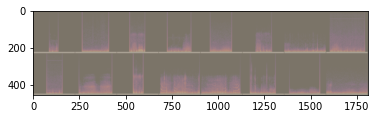

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        title=[x for x in classes]
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out) 

### Define training function

In [ ]:
def train(model, device, train_loader, val_loader, optimizer, n_epochs, criterion):

    # send the model (and data) to the device
    model.to(device)
    best_acc = 0
    for epoch in range(n_epochs):

        # switch to training mode
        model.train()
        total_loss = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            # move the data to the device (e.g., cuda)
            data, target = data.float().to(device), target.float().type(torch.LongTensor).to(device)
            # conver one hot target to label indices
#             _, labels = target.max(dim=1)
        
            # clean the gradient
            optimizer.zero_grad()
            
            
            # Get model output
            output = model(data)
            
            # Define the loss function for classification
            loss = criterion(output, target)

            # Backward pass
            loss.backward()

            # Call the optimizer
            optimizer.step()

            total_loss += loss.item()

        print('Train Epoch: {} \tLoss: {:.6f}'.format(
            epoch, total_loss / len(train_loader)), end='\t')
        
#         for name, param in model.named_parameters():
#             if param.requires_grad:
#                 print(name, param.data)
        
        # switch to evaluation mode
        model.eval()
        total_loss = 0
        acc = 0
        total_samples = 0
        precision_recall = 0
        for batch_idx, (data, target) in enumerate(val_loader):
            # move the data to the device (e.g., cuda)
            data, target = data.float().to(device), target.float().type(torch.LongTensor).to(device)
            
            # conver one hot target to label indices
#             _, labels = target.max(dim=1)
            
            # disable gradient 
            with torch.no_grad():
                
                # Get model output
                output = model(data)

                # Define the loss function for classification
                loss = criterion(output, target)

                # We can also test the validation accuracy
                true_positive = torch.count_nonzero(output.argmax(-1) == target)
                acc += true_positive
                
                # F1 score
#                 f1 = torchmetrics.F1Score(task = "multiclass", num_classes = 8, top_k = 1).to(device)
#                 precision_recall += f1(output.argmax(-1), target)
                total_samples += len(target)
                total_loss += loss.item()
                cur_acc =  acc/(total_samples)
        print('Val Loss: {:.6f}\t Val Acc: {:.6f}'.format(
            total_loss / len(val_loader), cur_acc))
        
        if cur_acc > best_acc:
            best_acc = cur_acc
    print('Best Accuracy: {:.6f}'.format(best_acc))
        

### Model Creation & Training & Evaluation

#### AlexNet Pretrained

In [ ]:
alex_model_pretrained = models.alexnet(pretrained = True)

# Freeze training for all features layers
for param in alex_model_pretrained.parameters():
    param.requires_grad = False

alex_model_pretrained.classifier.add_module('7', nn.Linear(1000, 8))
# print(alex_model_pretrained)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("You are training on", device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, alex_model_pretrained.parameters()), lr=0.0001)
train(alex_model_pretrained, device, dataloaders['train'], dataloaders['val'], optimizer, 50, criterion)

You are training on cuda
Train Epoch: 0 	Loss: 1.250871	Val Loss: 1.058962	 Val Acc: 0.633929
Train Epoch: 1 	Loss: 1.218342	Val Loss: 1.075789	 Val Acc: 0.571429
Train Epoch: 2 	Loss: 1.213274	Val Loss: 1.049525	 Val Acc: 0.586310
Train Epoch: 3 	Loss: 1.193391	Val Loss: 1.046370	 Val Acc: 0.604167
Train Epoch: 4 	Loss: 1.213783	Val Loss: 1.029265	 Val Acc: 0.645833
Train Epoch: 5 	Loss: 1.201830	Val Loss: 1.053220	 Val Acc: 0.598214
Train Epoch: 6 	Loss: 1.226242	Val Loss: 1.033901	 Val Acc: 0.604167
Train Epoch: 7 	Loss: 1.215814	Val Loss: 1.028749	 Val Acc: 0.616071
Train Epoch: 8 	Loss: 1.182601	Val Loss: 1.028547	 Val Acc: 0.607143
Train Epoch: 9 	Loss: 1.187809	Val Loss: 1.039168	 Val Acc: 0.595238
Train Epoch: 10 	Loss: 1.201292	Val Loss: 1.027796	 Val Acc: 0.639881
Train Epoch: 11 	Loss: 1.195504	Val Loss: 1.041508	 Val Acc: 0.607143
Train Epoch: 12 	Loss: 1.202646	Val Loss: 1.064090	 Val Acc: 0.574405
Train Epoch: 13 	Loss: 1.184662	Val Loss: 1.037147	 Val Acc: 0.589286
Train

#### AlexNet NOT Pretrained

In [ ]:
alex_model_not_pretrained = models.alexnet(pretrained = True)

# Freeze training for all features layers
for param in alex_model_not_pretrained.parameters():
    param.requires_grad = True

alex_model_not_pretrained.classifier.add_module('7', nn.Linear(1000, 8))
# print(alex_model_not_pretrained)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("You are training on", device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, alex_model_not_pretrained.parameters()), lr=0.0001)
train(alex_model_not_pretrained, device, dataloaders['train'], dataloaders['val'], optimizer, 50, criterion)

You are training on cuda
Train Epoch: 0 	Loss: 1.376050	Val Loss: 0.888886	 Val Acc: 0.636905
Train Epoch: 1 	Loss: 0.897856	Val Loss: 0.764549	 Val Acc: 0.705357
Train Epoch: 2 	Loss: 0.689389	Val Loss: 0.714471	 Val Acc: 0.741071
Train Epoch: 3 	Loss: 0.564835	Val Loss: 0.536380	 Val Acc: 0.809524
Train Epoch: 4 	Loss: 0.532217	Val Loss: 0.651785	 Val Acc: 0.776786
Train Epoch: 5 	Loss: 0.435526	Val Loss: 0.411202	 Val Acc: 0.854167
Train Epoch: 6 	Loss: 0.304954	Val Loss: 0.441324	 Val Acc: 0.845238
Train Epoch: 7 	Loss: 0.249077	Val Loss: 0.320197	 Val Acc: 0.907738
Train Epoch: 8 	Loss: 0.232394	Val Loss: 0.451291	 Val Acc: 0.860119
Train Epoch: 9 	Loss: 0.255503	Val Loss: 0.592128	 Val Acc: 0.830357
Train Epoch: 10 	Loss: 0.217351	Val Loss: 0.591191	 Val Acc: 0.869048
Train Epoch: 11 	Loss: 0.185425	Val Loss: 0.389475	 Val Acc: 0.886905
Train Epoch: 12 	Loss: 0.150121	Val Loss: 0.457744	 Val Acc: 0.880952
Train Epoch: 13 	Loss: 0.131060	Val Loss: 0.705366	 Val Acc: 0.833333
Train

#### VGG16 Pretrained

In [ ]:
vgg_model_pretrained = models.vgg16(pretrained=True)

for param in vgg_model_pretrained.parameters():
    param.requires_grad = False

vgg_model_pretrained.classifier.add_module('7', nn.Linear(1000, 8))
# print(vgg_model_pretrained)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("You are training on", device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, vgg_model_pretrained.parameters()), lr=0.0001)
train(vgg_model_pretrained, device, dataloaders['train'], dataloaders['val'], optimizer, 50, criterion)

You are training on cuda
Train Epoch: 0 	Loss: 1.948587	Val Loss: 1.678287	 Val Acc: 0.330357
Train Epoch: 1 	Loss: 1.712396	Val Loss: 1.578320	 Val Acc: 0.377976
Train Epoch: 2 	Loss: 1.640095	Val Loss: 1.516767	 Val Acc: 0.428571
Train Epoch: 3 	Loss: 1.620395	Val Loss: 1.502350	 Val Acc: 0.389881
Train Epoch: 4 	Loss: 1.581854	Val Loss: 1.459529	 Val Acc: 0.416667
Train Epoch: 5 	Loss: 1.528527	Val Loss: 1.456344	 Val Acc: 0.422619
Train Epoch: 6 	Loss: 1.524889	Val Loss: 1.415142	 Val Acc: 0.443452
Train Epoch: 7 	Loss: 1.500455	Val Loss: 1.399532	 Val Acc: 0.434524
Train Epoch: 8 	Loss: 1.504678	Val Loss: 1.387170	 Val Acc: 0.476190
Train Epoch: 9 	Loss: 1.490745	Val Loss: 1.388298	 Val Acc: 0.464286
Train Epoch: 10 	Loss: 1.482698	Val Loss: 1.369125	 Val Acc: 0.470238
Train Epoch: 11 	Loss: 1.458726	Val Loss: 1.348892	 Val Acc: 0.482143
Train Epoch: 12 	Loss: 1.454835	Val Loss: 1.339921	 Val Acc: 0.508929
Train Epoch: 13 	Loss: 1.449232	Val Loss: 1.339932	 Val Acc: 0.505952
Train

#### VGG16 NOT Pretrained

In [ ]:
vgg_model_not_pretrained = models.vgg16(pretrained=True)

for param in vgg_model_not_pretrained.parameters():
    param.requires_grad = True

vgg_model_not_pretrained.classifier.add_module('7', nn.Linear(1000, 8))
# print(vgg_model_not_pretrained)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("You are training on", device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, vgg_model_not_pretrained.parameters()), lr=0.0001)
train(vgg_model_not_pretrained, device, dataloaders['train'], dataloaders['val'], optimizer, 50, criterion)

You are training on cuda
Train Epoch: 0 	Loss: 1.447395	Val Loss: 1.160660	 Val Acc: 0.541667
Train Epoch: 1 	Loss: 0.883954	Val Loss: 0.686744	 Val Acc: 0.776786
Train Epoch: 2 	Loss: 0.741417	Val Loss: 0.552928	 Val Acc: 0.779762
Train Epoch: 3 	Loss: 0.571709	Val Loss: 0.505591	 Val Acc: 0.830357
Train Epoch: 4 	Loss: 0.530073	Val Loss: 0.515485	 Val Acc: 0.851191
Train Epoch: 5 	Loss: 0.387282	Val Loss: 0.362546	 Val Acc: 0.875000
Train Epoch: 6 	Loss: 0.335303	Val Loss: 0.442228	 Val Acc: 0.880952
Train Epoch: 7 	Loss: 0.274441	Val Loss: 0.396912	 Val Acc: 0.872024
Train Epoch: 8 	Loss: 0.247335	Val Loss: 0.280272	 Val Acc: 0.919643
Train Epoch: 9 	Loss: 0.234671	Val Loss: 0.405126	 Val Acc: 0.883929
Train Epoch: 10 	Loss: 0.102484	Val Loss: 0.764476	 Val Acc: 0.833333
Train Epoch: 11 	Loss: 0.124411	Val Loss: 0.347616	 Val Acc: 0.925595
Train Epoch: 12 	Loss: 0.220515	Val Loss: 0.582581	 Val Acc: 0.827381
Train Epoch: 13 	Loss: 0.174987	Val Loss: 0.381367	 Val Acc: 0.898810
Train